In [1]:
%config IPCompleter.use_jedi=False

import os
import tensorflow as tf
import tensorflow
from tensorflow import keras
import numpy as np
import pathlib
from functools import partial
import pandas as pd
import time
from platform import python_version
from datetime import datetime

print("python_version: ", python_version())
print("TensorFlow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))
from glob import glob
# from helper import *

import tensorflow as tf
import os
import pandas as pd
from datetime import datetime

from augmentation import *
transforms = transformations()

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

python_version:  3.8.10
TensorFlow version: 2.4.0
Keras version: 2.4.0


In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [3]:
# # specifically working for dgx not on local
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
# os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

In [4]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(8):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
#         ax.imshow(image[i].astype(np.uint8))
#         ax.imshow(image[i].astype("int32"))
        ax.imshow(image[i])
#         print(image)
        ax.set_title(f"Label: {label[i]}")

In [5]:

def print_layers_state(model):
    layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
    layer_df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
    return layer_df

def cardinality_check(ds):
    num = tf.data.experimental.cardinality(ds).numpy()
    return num

def set_tensorflow_config(per_process_gpu_memory_fraction=0.7):
    config = tf.compat.v1.ConfigProto()
    # config = tf.ConfigProto()
    # config.gpu_options.per_process_gpu_memory_fraction = per_process_gpu_memory_fraction
    config.gpu_options.allow_growth=True
    # sess = tf.Session(config=config)
    sess = tf.compat.v1.Session(config=config)
    print("== TensorFlow Config options set ==")
    print("\nThis process will now utilize {} GPU Memeory Fraction".format(per_process_gpu_memory_fraction))


In [6]:
set_tensorflow_config()

== TensorFlow Config options set ==

This process will now utilize 0.7 GPU Memeory Fraction


In [7]:
abs_dataset_path = '/home/ubuntu/mount/Notebooks/abg/anuj_ws/image-datasets/cats_vs_dogs_redux/original/train/'

In [8]:
data_dir = pathlib.Path(abs_dataset_path)

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

25000


In [10]:
# tf way 
# class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

# simple way?
CLASS_NAMES =  sorted(os.listdir(data_dir))

print(CLASS_NAMES)
NUM_CLASSES = len(CLASS_NAMES)

['cats', 'dogs']


In [11]:
list_ds_files = tf.data.Dataset.list_files(str(data_dir)+'/*/*', shuffle=False)
# list_ds = list_ds_files.interleave(lambda x: list_ds_files, cycle_length=4)
list_ds = list_ds_files.shuffle(image_count, reshuffle_each_iteration=False)

In [12]:
cardinality_check(list_ds)

25000

In [13]:
def split_dataset(dataset, validation_size=0.3, test_size=0.1):
    ## return train, validation and test datasets
    image_count = dataset.cardinality().numpy()
    val_size = int(image_count*validation_size)
    test_size = int(image_count*test_size)
    validation_dataset = dataset.take(val_size)
    dataset = dataset.skip(val_size)
    test_dataset = dataset.take(test_size)
    train_dataset = dataset.skip(test_size)
    
    return train_dataset, validation_dataset, test_dataset


In [14]:
train_ds, validation_ds, test_ds = split_dataset(dataset=list_ds)

In [15]:
NUM_TRAIN_FILES = cardinality_check(train_ds)
NUM_VALIDATION_FILES = cardinality_check(validation_ds)
NUM_TEST_FILES = cardinality_check(test_ds)

In [16]:
BATCH_SIZE = 8
EPOCHS = 1
TL_LEARNING_RATE = 0.001
FT_LEARNING_RATE = 0.00001
DROPOUT_RATE = 0.4
SHUFFLE_BUFFER_SIZE = 1000

TRAIN_STEP_PER_EPOCHS = NUM_TRAIN_FILES/BATCH_SIZE
VALIDATION_STEPS_PER_EPOCHS = NUM_VALIDATION_FILES/BATCH_SIZE
TEST_STEPS_PER_EPOCHS = NUM_TEST_FILES/BATCH_SIZE

DATA_BUFFER_SIZE = 20000
AUTOTUNE = tf.data.AUTOTUNE

EXPERIMENT_NAME = 'cats_vs_dogs_model'



ONE_HOT = True

# sparse_categorical, binary
# CLASS_TYPE = 'sparse_categorical'

if NUM_CLASSES < 2:
    ONE_HOT = False
    CLASSIFIER = 'sigmoid'
    CLASS_TYPE = 'binary' 
else:
    CLASSIFIER = 'softmax'
    if not ONE_HOT:
        CLASS_TYPE = 'sparse_categorical'


IMG_SIZE = 224

INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [17]:
print("step size for training: ", TRAIN_STEP_PER_EPOCHS)
print("step size for validation: ", VALIDATION_STEPS_PER_EPOCHS)
print("step size for test: ", TEST_STEPS_PER_EPOCHS)

step size for training:  1875.0
step size for validation:  937.5
step size for test:  312.5


In [18]:
def get_label(is_one_hot, CLASS_NAMES, NUM_CLASSES, file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    bool_label = parts[-2] == CLASS_NAMES
    # Integer encode the label
    int_label = tf.argmax(tf.cast(bool_label, tf.int32))
    # return either one hot or sparse label set
    if is_one_hot:
        one_hot_label = tf.one_hot(int_label, NUM_CLASSES)
        return one_hot_label
    else:
        return int_label

In [19]:
# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
#     # aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img


# def process_aug_image(image, img_size, aug_fn):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img


# def process_with_aug(is_one_hot, CLASS_NAMES, NUM_CLASSES, IMG_SIZE, preprocess_input, aug_fn, file_path):
#     label = get_label(is_one_hot, CLASS_NAMES, NUM_CLASSES, file_path)
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)
#     img = tf.io.decode_jpeg(img, channels=3)
#     img = process_aug_image(img, IMG_SIZE, aug_fn)
#     img = preprocess_input(img)
#     return img, label

# def set_shapes(ONE_HOT, image_size, num_classes, img, label):
#     img_shape=(image_size, image_size, 3)
#     img.set_shape(img_shape)
#     if ONE_HOT:
#         label.set_shape([num_classes])
#     else:
#         label.set_shape([])
#     return img, label

# # def process_without_aug(is_one_hot, CLASS_NAMES, NUM_CLASSES, IMG_SIZE, preprocess_input, file_path):
# #     label = get_label(is_one_hot, CLASS_NAMES, NUM_CLASSES, file_path)
# #     # load the raw data from the file as a string
# #     img = tf.io.read_file(file_path)
# #     # convert the compressed string to a 3D uint8 tensor
# #     img = tf.io.decode_jpeg(img, channels=3)
# #     # resize the image to the desired size
# #     img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
# #     img = preprocess_input(img)
# #     return img, label



In [20]:
def parse_image(is_one_hot, CLASS_NAMES, NUM_CLASSES, IMG_SIZE, file_path):
    label = get_label(is_one_hot, CLASS_NAMES, NUM_CLASSES, file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    
    return img, label

In [21]:
def model_preprocess(preprocess_input, image, label):
    print(image, label)
    return preprocess_input(image), label

In [22]:
# def tf_data_augmentation(image, label):
#     image = tf.image.random_flip_left_right(image)

#     image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

#     #Make sure the image is still in [0, 1]
#     image = tf.clip_by_value(image, 0.0, 1.0)
    
#     return image, label

In [23]:
def configure_for_performance(ds, batch_size, preprocess_fun, is_train, cache_file_name=None, augment=False, shuffle_buffer_size=1000):
    # use only when the dataset is small
    if cache_file_name is not None:
        ds = ds.cache(cache_file_name)
    
    if augment:
        #ds = ds.map(tf_data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
        pass
    
    # include autotune in map here
    ds = ds.map(partial(model_preprocess, preprocess_fun), num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        print("Train flag supplied")
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # I think if you do not repeat this in validation then the pipeline should fail after all the images are over
    ds = ds.repeat()
    # this is correct, batching should be done after repeat
    # once the data is exhausted, repeat will replenish the data
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

## train

In [24]:
train_ds = train_ds.interleave(lambda x: train_ds, cycle_length=4)

In [25]:
train_ds = train_ds.map(partial(parse_image, 
                                ONE_HOT, 
                                CLASS_NAMES, 
                                NUM_CLASSES, 
                                IMG_SIZE,
                               ), 
                        num_parallel_calls=AUTOTUNE
                       )

In [26]:
train_ds

<ParallelMapDataset shapes: ((224, 224, 3), (2,)), types: (tf.float32, tf.float32)>

In [27]:
train_ds = configure_for_performance(train_ds, BATCH_SIZE, preprocess_input, is_train=True, augment=True)

Tensor("args_0:0", shape=(224, 224, 3), dtype=float32) Tensor("args_1:0", shape=(2,), dtype=float32)
Train flag supplied


In [28]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

## validation

In [29]:
validation_ds = validation_ds.interleave(lambda x: validation_ds, cycle_length=4)

In [30]:
validation_ds = validation_ds.map(partial(parse_image, 
                                ONE_HOT, 
                                CLASS_NAMES, 
                                NUM_CLASSES, 
                                IMG_SIZE,
                               ), 
                        num_parallel_calls=AUTOTUNE
                       )

In [31]:
validation_ds

<ParallelMapDataset shapes: ((224, 224, 3), (2,)), types: (tf.float32, tf.float32)>

In [32]:
validation_ds = configure_for_performance(validation_ds, BATCH_SIZE, preprocess_input, is_train=False)

Tensor("args_0:0", shape=(224, 224, 3), dtype=float32) Tensor("args_1:0", shape=(2,), dtype=float32)


In [33]:
validation_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

## test

In [34]:
test_ds = test_ds.interleave(lambda x: test_ds, cycle_length=4)

In [35]:
test_ds = test_ds.map(partial(parse_image, 
                                ONE_HOT, 
                                CLASS_NAMES, 
                                NUM_CLASSES, 
                                IMG_SIZE,
                               ), 
                        num_parallel_calls=AUTOTUNE
                       )

In [36]:
test_ds

<ParallelMapDataset shapes: ((224, 224, 3), (2,)), types: (tf.float32, tf.float32)>

In [37]:
test_ds = configure_for_performance(test_ds, BATCH_SIZE, preprocess_input, is_train=False)

Tensor("args_0:0", shape=(224, 224, 3), dtype=float32) Tensor("args_1:0", shape=(2,), dtype=float32)


In [38]:
test_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

In [39]:
base_model = MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=INPUT_SHAPE,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

In [40]:
# Create new model on top
inputs = keras.Input(shape=INPUT_SHAPE)
# x = data_augmentation(inputs)  # Apply random data augmentation

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
# x = base_model(x, training=False)
# x = preprocess_input(inputs)
x = base_model(inputs, training=False)
# from here till the classifier layer, it is all experimental 
# as to how many layers we think would be required that can help build a better model for our dataset

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
x = keras.layers.Dense(1024, activation='relu',name='fc-1')(x)
# x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.Dense(256, activation='relu',name='fc-2')(x)
#x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
fc-1 (Dense)                 (None, 1024)              1311744   
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,571,778
Trainable params: 1,313,794
Non-trainable params: 2,257,984
___________________________________________

In [41]:
if ONE_HOT:
    metrics = [tf.keras.metrics.CategoricalCrossentropy(),
               #tf.keras.metrics.CategoricalAccuracy()
              ]
    loss = [tensorflow.keras.losses.CategoricalCrossentropy()]
    metric_to_monitor = 'val_categorical_accuracy'
else:
    if CLASS_TYPE == 'sparse_categorical':
        metrics = [tf.keras.metrics.SparseCategoricalCrossentropy(),
                   #tf.keras.metrics.SparseCategoricalAccuracy()
                  ]
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()]
        metric_to_monitor = 'val_sparse_categorical_crossentropy'
    elif CLASS_TYPE == 'binary':
        metrics = [tf.keras.metrics.BinaryCrossentropy(),
                   #tf.keras.metrics.BinaryAccuracy()
                  ]
        loss = [tf.keras.losses.BinaryCrossentropy()]
        metric_to_monitor = 'binary_crossentropy'

In [42]:
optimizer = tensorflow.keras.optimizers.Adam()
model.compile(loss=loss, 
              optimizer=optimizer, 
              #metrics=[tf.keras.metrics.CategoricalCrossentropy(),
                       #tf.keras.metrics.CategoricalAccuracy()]
             metrics = metrics
             )

In [43]:
start_time= time.perf_counter()

history = model.fit(
            train_ds,
            steps_per_epoch = TRAIN_STEP_PER_EPOCHS,
            validation_data = validation_ds,
            validation_steps = VALIDATION_STEPS_PER_EPOCHS,
            
            epochs=EPOCHS
)

end_time = time.perf_counter()

print(end_time-start_time)

1875/1875 [==============================] - 35s 16ms/step - loss: 0.7810 - categorical_crossentropy: 0.7810 - val_loss: 0.7056 - val_categorical_crossentropy: 0.7056
34.719448641873896


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


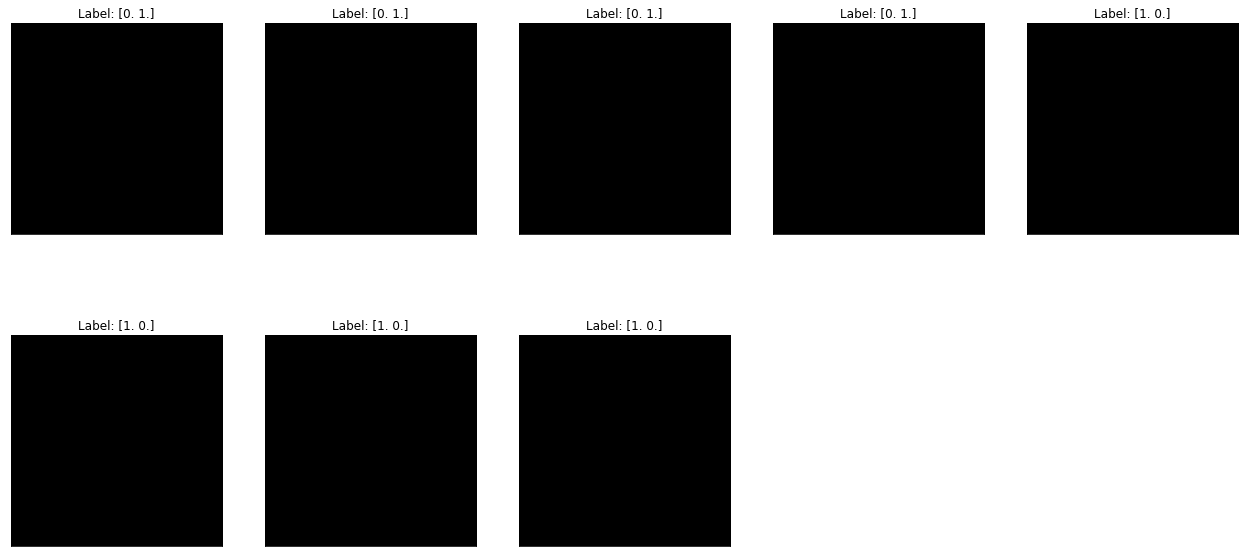

In [44]:
view_image(validation_ds.take(1))

# References
1. https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
2. https://cs230.stanford.edu/blog/datapipeline/#building-an-image-data-pipeline
3. https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5